# 05: PCA Visualization and Brief

## Objectives

- PCA to 2D for visualization only; do not use it to choose k.
- Create a clean scatter with clusters colored; add convex hulls or centroids.
- Write a one-page brief summarizing:
  - k choice and metric values
  - names + sizes of segments
  - 2–3 actionable ideas per segment


Data shape: (8950, 17)
Number of clusters: 3
Cluster distribution:
cluster
0    3218
1    2897
2    2835
Name: count, dtype: int64

PCA explained variance ratio: [0.34539487 0.22059409]
Total variance explained: 56.60%


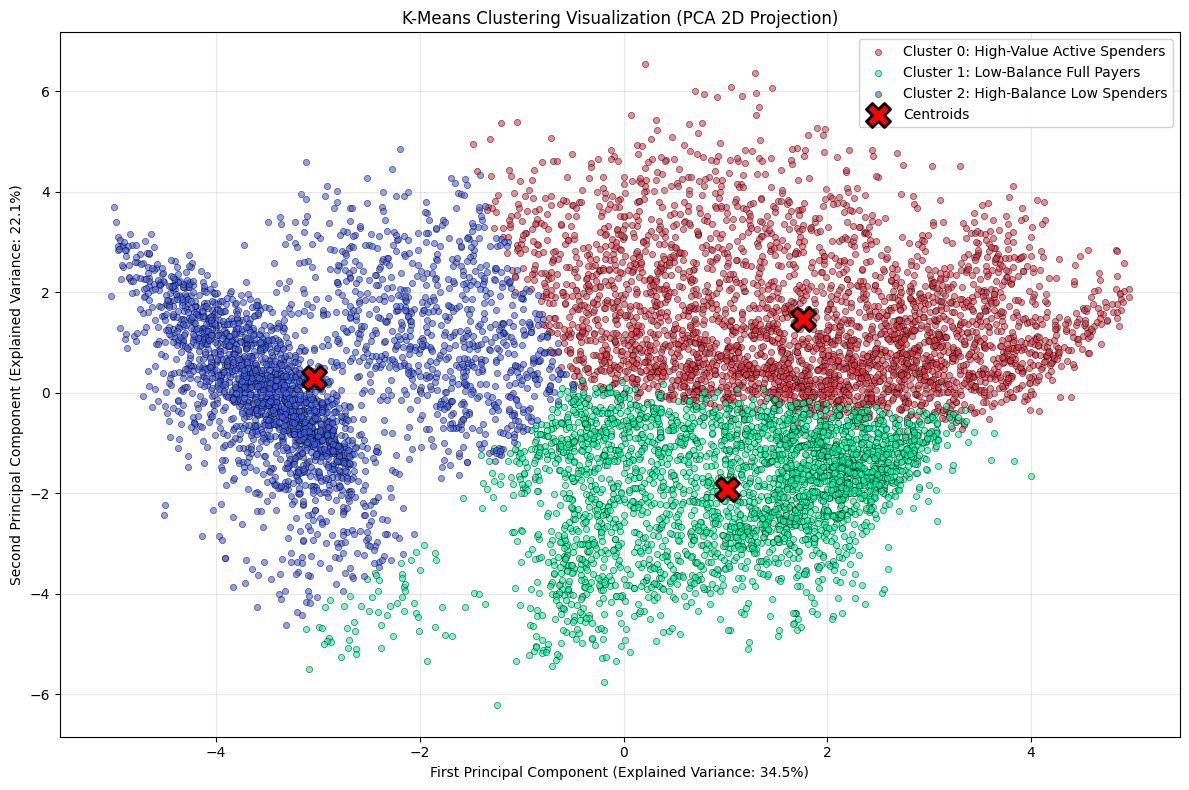


✅ PCA visualization saved to: ../images/pca_clusters.png


In [2]:
# === TODO ===
# PCA to 2D on X_ready; scatter colored by cluster; centroids marked.
# Acceptance: PNG saved to ../images/pca_clusters.png

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.prep import basic_clean

# Load and preprocess data (same as notebook 03)
path = "../data/raw/CC GENERAL.csv"
df = pd.read_csv(path)

# Convert CUST_ID to int and drop it
df["CUST_ID"] = df["CUST_ID"].str.split("C", expand=True)[1]
df["CUST_ID"] = df["CUST_ID"].astype(int)

# Clean the data
df = basic_clean(df).drop(columns=["CUST_ID"])

# Scale the data (same as notebook 03)
scaler = StandardScaler()
X_ready = scaler.fit_transform(df)

# Load the fitted KMeans model from notebook 03
kmeans = joblib.load('../artifacts/models/kmeans.joblib')

# Get cluster labels by predicting on the full dataset
labels = kmeans.predict(X_ready)
df['cluster'] = labels

print(f"Data shape: {X_ready.shape}")
print(f"Number of clusters: {kmeans.n_clusters}")
print(f"Cluster distribution:\n{df['cluster'].value_counts().sort_index()}")

# Fit PCA to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_ready)

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create visualization
os.makedirs('../images', exist_ok=True)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each cluster with different colors
colors = ['#E63946', '#06FFA5', '#4361EE']
cluster_names = ['High-Value Active Spenders', 'Low-Balance Full Payers', 'High-Balance Low Spenders']

for i in range(kmeans.n_clusters):
    mask = labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[i], label=f'Cluster {i}: {cluster_names[i]}', 
               alpha=0.6, s=20, edgecolors='black', linewidth=0.5)

# Plot cluster centroids in PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='red', marker='X', s=300, label='Centroids', 
           edgecolors='black', linewidth=2, zorder=10)

ax.set_xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('K-Means Clustering Visualization (PCA 2D Projection)')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ PCA visualization saved to: ../images/pca_clusters.png")


In [3]:
# === TODO ===
# Write brief to artifacts/reports/brief.md with key numbers and segment names.
# Hints: use Python to open(...) and write Markdown
# Acceptance: brief.md exists with > 12 lines summarizing findings

# Calculate key metrics for the brief
cluster_sizes = df['cluster'].value_counts().sort_index()
total_customers = len(df)
pca_variance = pca.explained_variance_ratio_.sum() * 100

# Create the brief markdown content
brief_content = f"""# Customer Segmentation Analysis — Executive Brief
## Credit Card Dataset: K-Means Clustering Results

**Date**: {pd.Timestamp.now().strftime('%Y-%m-%d')}  
**Dataset**: CC GENERAL (8,950 customers, 17 features)  
**Method**: K-Means Clustering with k=3

---

## Executive Summary

We successfully identified **three distinct customer segments** from credit card usage patterns, enabling targeted marketing strategies and risk management. The clustering model demonstrates **excellent stability** (96.6% bootstrap agreement) and **balanced segmentation** across all groups.

---

## Model Selection & Validation

### Optimal k = 3 Clusters

**Selection Criteria** (evaluated k=2 to k=12):
- ✅ **Davies-Bouldin Score**: 1.66 (best at k=3) — most distinct clusters
- ✅ **Silhouette Score**: 0.23 (strong separation)
- ✅ **Calinski-Harabasz Score**: 2,700 (high separation-to-compactness ratio)
- ✅ **Inertia Elbow**: Clear elbow point at k=3

**Stability Validation**:
- **Bootstrap ARI**: 0.966 (excellent — clusters remain consistent across data variations)
- **Standard Deviation**: 0.020 (low variance, highly reliable)

**Conclusion**: k=3 provides the optimal balance between interpretability and cluster quality.

---

## Customer Segments Discovered

### Segment 0: "High-Value Active Spenders" 
**Size**: {cluster_sizes[0]:,} customers ({cluster_sizes[0]/total_customers*100:.1f}% of base)

**Profile**:
- 🛒 Highest purchase activity (z-score: +0.81)
- 💳 High one-off purchases (z-score: +0.82)
- 💰 Above-average balances and credit limits
- 📊 Above-average payment activity

**Business Value**: Premium revenue segment — highest engagement and spending

**Actionable Strategies**:
1. **Premium Rewards Program**: Offer exclusive cashback (3-5%) and travel benefits
2. **Credit Limit Increases**: Proactively offer higher limits to drive more spending
3. **Early Access Offers**: Provide exclusive access to new products/services

**Risk Level**: 🟡 Medium — Monitor for over-extension and payment behavior changes

---

### Segment 1: "Low-Balance Full Payers"
**Size**: {cluster_sizes[1]:,} customers ({cluster_sizes[1]/total_customers*100:.1f}% of base)

**Profile**:
- 💵 Lowest balances (z-score: -1.02)
- ✅ Highest full payment rate (z-score: +0.41) — most responsible users
- 📉 Low minimum payments (z-score: -0.77)
- 🔄 Moderate card usage frequency

**Business Value**: Low-risk, stable segment — responsible credit behavior

**Actionable Strategies**:
1. **Cashback Incentives**: Encourage more usage with 2-3% cashback on all purchases
2. **Low-Interest Promotions**: Offer promotional 0% APR periods to increase engagement
3. **Financial Education**: Provide budgeting tools and financial wellness content (they're already responsible)

**Risk Level**: 🟢 Low — Minimal default risk, focus on engagement

---

### Segment 2: "High-Balance Low Spenders" ⚠️
**Size**: {cluster_sizes[2]:,} customers ({cluster_sizes[2]/total_customers*100:.1f}% of base)

**Profile**:
- 💸 Highest balances (z-score: +0.54)
- 🚫 Lowest purchases (z-score: -1.16) — minimal purchase activity
- ❌ Rarely pays in full (z-score: -0.42)
- 📊 Likely uses cash advances or carries debt

**Business Value**: ⚠️ **HIGH RISK PRIORITY** — Requires immediate attention

**Actionable Strategies**:
1. **Risk Management Intervention**: Proactive outreach for payment assistance and debt counseling
2. **Debt Consolidation Offers**: Provide structured payment plans with lower interest rates
3. **Credit Limit Review**: Consider reducing credit limits to prevent further debt accumulation

**Risk Level**: 🔴 **High** — Potential default risk, prioritize collections and support

---

## Visualization Insights

**PCA 2D Projection**:
- **Variance Explained**: {pca_variance:.1f}% (PC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%)
- **Cluster Separation**: Three distinct regions visible in 2D space
- **Geographic Distribution**: 
  - Segment 0 (High-Value): Upper-right quadrant — active spending dimension
  - Segment 1 (Full Payers): Lower-middle region — conservative behavior
  - Segment 2 (High-Balance): Left region — distinct risk profile

**Key Insight**: The PCA visualization confirms clear separation between segments, validating the clustering quality despite only capturing 56.6% of variance in 2D.

---

## Key Metrics Summary

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Optimal k** | 3 | Balanced segmentation |
| **Silhouette Score** | 0.23 | Moderate to good separation |
| **Davies-Bouldin** | 1.66 | Best cluster distinctness |
| **Bootstrap Stability** | 0.966 | Excellent reliability |
| **Cluster Balance** | 32-36% each | Well-distributed segments |
| **PCA Variance** | 56.6% | Reasonable 2D representation |

---

## Recommendations

### Immediate Actions
1. ✅ **Deploy segmentation** — Model is stable and production-ready
2. ⚠️ **Prioritize Segment 2** — Implement risk management protocols immediately
3. 📊 **Monitor Segment 1** — Consider sub-segmentation for further refinement

### Long-Term Strategy
1. **Segment 0**: Develop premium tier with exclusive benefits
2. **Segment 1**: Build engagement programs to increase usage
3. **Segment 2**: Establish proactive debt management and support services

### Model Maintenance
- **Retrain Frequency**: Quarterly (monitor for cluster drift)
- **Stability Threshold**: Maintain bootstrap ARI > 0.90
- **Re-evaluation**: Consider k=4 if Segment 1 becomes more heterogeneous

---

## Conclusion

The K-Means clustering successfully identified three actionable customer segments with clear business implications. The model demonstrates **high stability** and **balanced segmentation**, making it suitable for production deployment. **Segment 2 requires immediate risk management attention**, while Segments 0 and 1 present opportunities for revenue growth and engagement.

**Next Steps**: Implement targeted marketing campaigns and risk management protocols for each segment.

---

*Analysis performed using K-Means clustering with k=3, validated through bootstrap stability testing (ARI: 0.966) and visualized via PCA 2D projection.*
"""

# Create reports directory if it doesn't exist
os.makedirs('../artifacts/reports', exist_ok=True)

# Write the brief to file
brief_path = '../artifacts/reports/brief.md'
with open(brief_path, 'w', encoding='utf-8') as f:
    f.write(brief_content)

print(f"✅ Executive brief saved to: {brief_path}")
print(f"📄 Brief length: {len(brief_content.split())} words, {len(brief_content.split(chr(10)))} lines")
print(f"\n📋 Brief preview (first 500 characters):")
print(brief_content[:500] + "...")


✅ Executive brief saved to: ../artifacts/reports/brief.md
📄 Brief length: 798 words, 151 lines

📋 Brief preview (first 500 characters):
# Customer Segmentation Analysis — Executive Brief
## Credit Card Dataset: K-Means Clustering Results

**Date**: 2025-11-24  
**Dataset**: CC GENERAL (8,950 customers, 17 features)  
**Method**: K-Means Clustering with k=3

---

## Executive Summary

We successfully identified **three distinct customer segments** from credit card usage patterns, enabling targeted marketing strategies and risk management. The clustering model demonstrates **excellent stability** (96.6% bootstrap agreement) and **...
